In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyscenic
import loompy as lp
import scanpy as sc
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

# Preparation of the NeurIPs dataset

In [4]:
adata = sc.read_h5ad("GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")
adata.shape

(69249, 129921)

In [5]:
# Subset RNA only features using the label GEX
rna = adata[:, adata.var.feature_types == "GEX"]
del adata
sc.pp.log1p(rna)
rna.obs.batch.value_counts()

s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: batch, dtype: int64

In [6]:
rna.shape

(69249, 13431)

In [7]:
sc.pp.highly_variable_genes(rna, batch_key="batch", flavor="seurat")

In [8]:
sc.set_figure_params(facecolor="white")

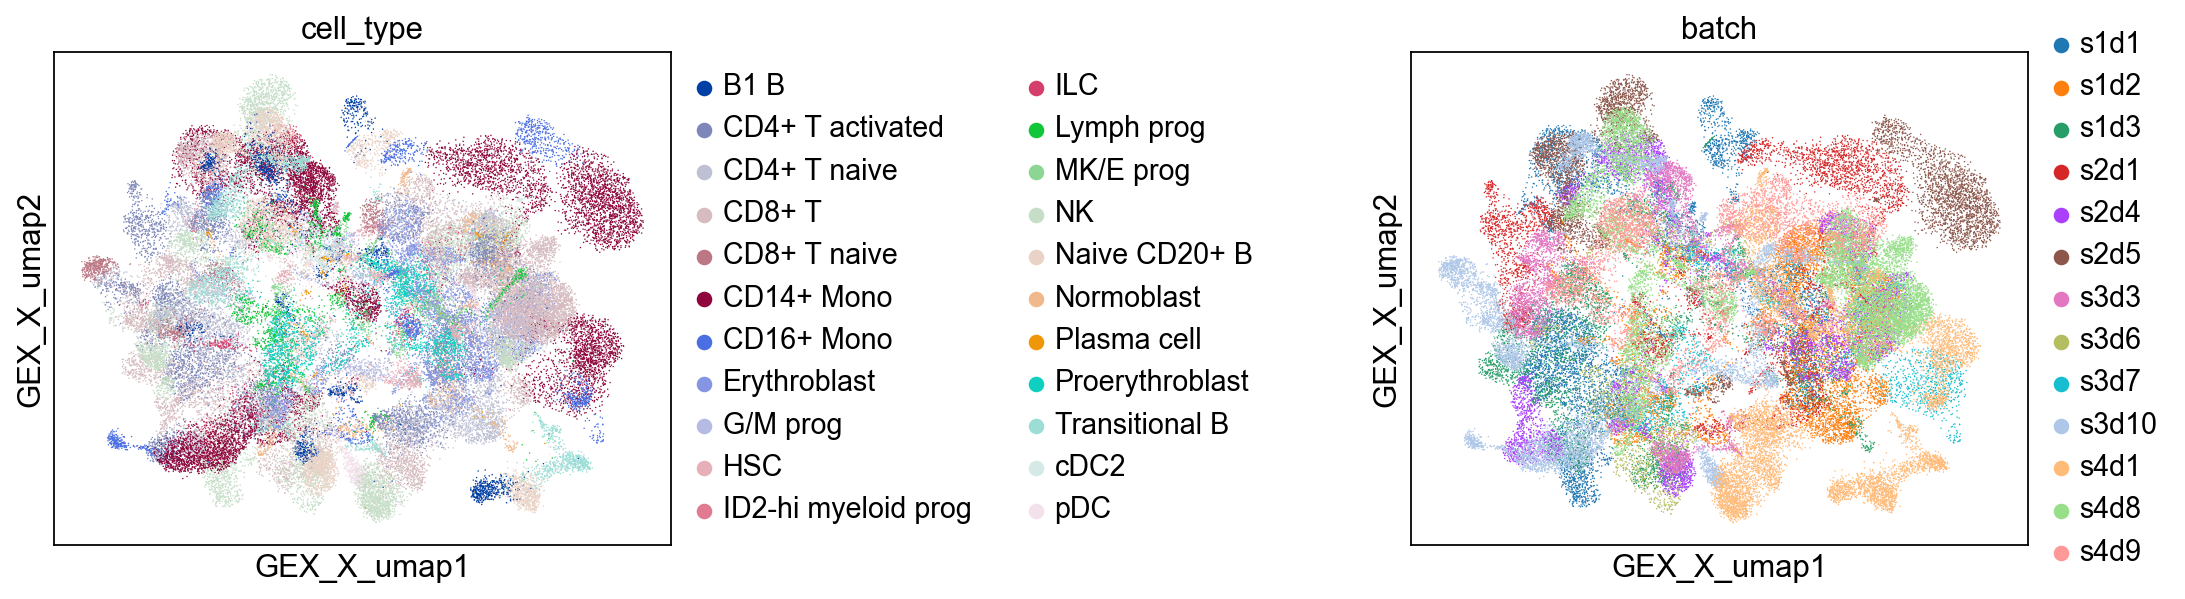

In [11]:
sc.pl.embedding(rna, "GEX_X_umap", color=["cell_type", "batch"], wspace=1)

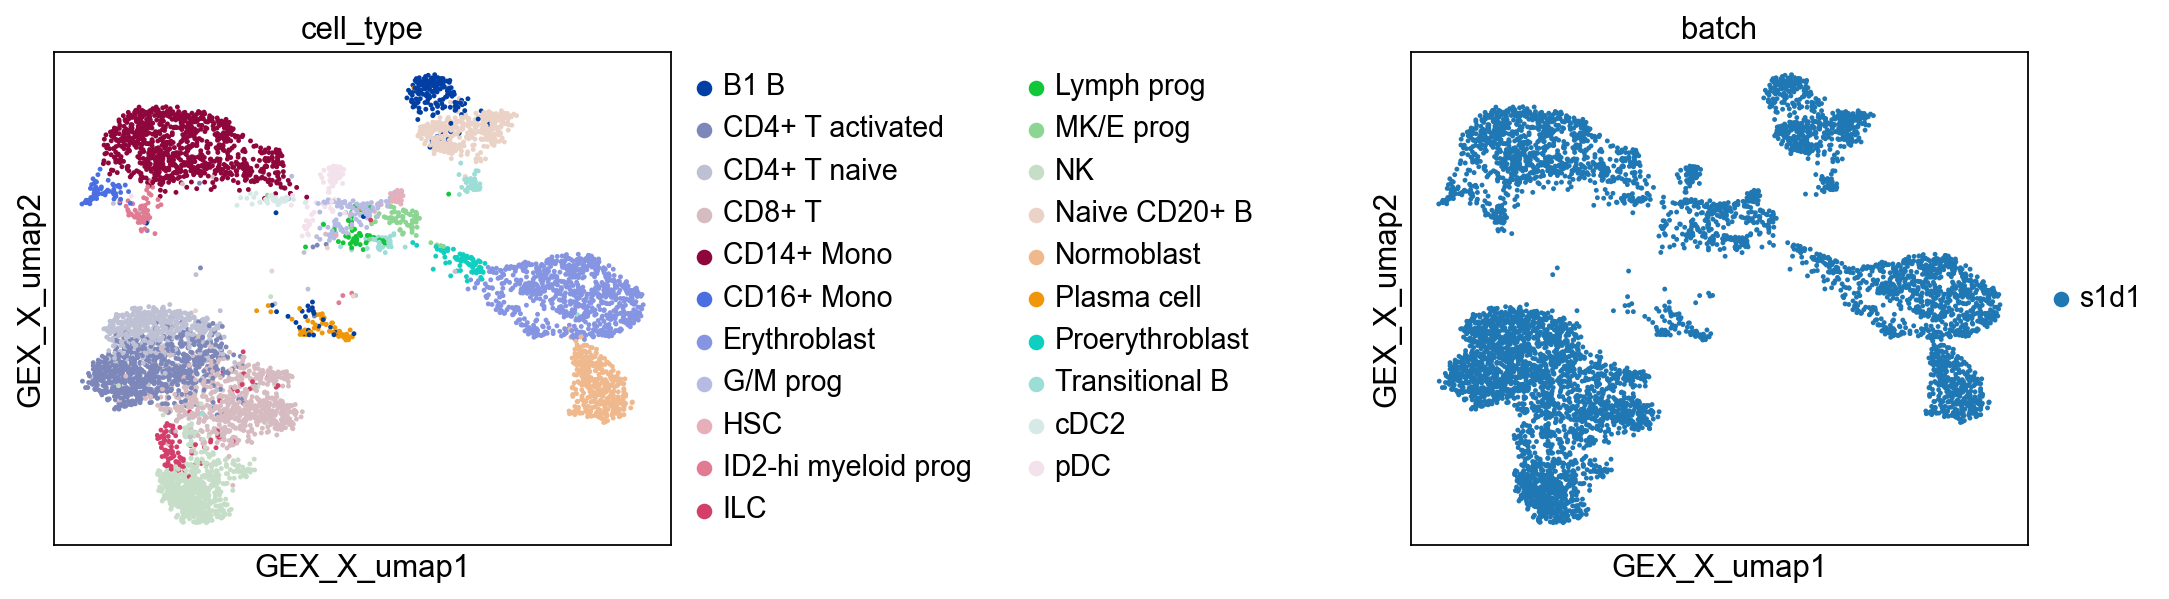

In [13]:
adata_batch = rna[rna.obs.batch == "s1d1", :]
sc.pl.embedding(adata_batch, "GEX_X_umap", color=["cell_type", "batch"], wspace=1)

# Preparation of SCENIC

In [ ]:
## this file has to be downloaded if not found
# wget -nc https://raw.githubusercontent.com/aertslab/SCENICprotocol/master/example/allTFs_hg38.txt

In [16]:
tfs_path = "allTFs_hg38.txt"

In [17]:
loom_path = "neurips_processed_input.loom"
loom_path_output = "neurips_processed_output.loom"
tfs = [tf.strip() for tf in open(tfs_path)]

In [19]:
# as a general QC. We inspect that our object has transcription factors listed in our main annotations.
print(
    f"{np.sum(adata_batch.var.index.isin(tfs))} out of {len(tfs)} TFs are found in the object"
)

1160 out of 1797 TFs are found in the object


In [20]:
use_hvg = True
if use_hvg:
    mask = (adata_batch.var["highly_variable"] == True) | adata_batch.var.index.isin(
        tfs
    )
    adata_batch = adata_batch[:, mask]

In [21]:
row_attributes = {
    "Gene": np.array(adata_batch.var.index),
}
col_attributes = {
    "CellID": np.array(adata_batch.obs.index),
    "nGene": np.array(np.sum(adata_batch.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(adata_batch.X.transpose(), axis=0)).flatten(),
}

# Using loompy to convert the gene expression values into loom files
lp.create(loom_path, adata_batch.X.transpose(), row_attributes, col_attributes)

In [27]:
# us pyscenic to generate associations between TFs and genes
num_workers = 16
outpath_adj = "adj.csv"
if not os.path.exists(outpath_adj):
    !pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --num_workers {num_workers}

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/mowp/mambaforge/en

In [34]:
# Show the top of TF-target associations

results_adjacencies = pd.read_csv("adj.csv", index_col=False, sep=",")
print(f"Number of associations: {results_adjacencies.shape[0]}")
results_adjacencies.head()

Number of associations: 222583


,TF,target,importance
0,SOX6,SLC4A1,42.942166
1,SOX6,HBA1,31.770726
2,SOX6,HBD,29.286729
3,SOX6,BLVRB,26.970335
4,SOX6,HBA2,24.715046


(-10.0, 10.0)

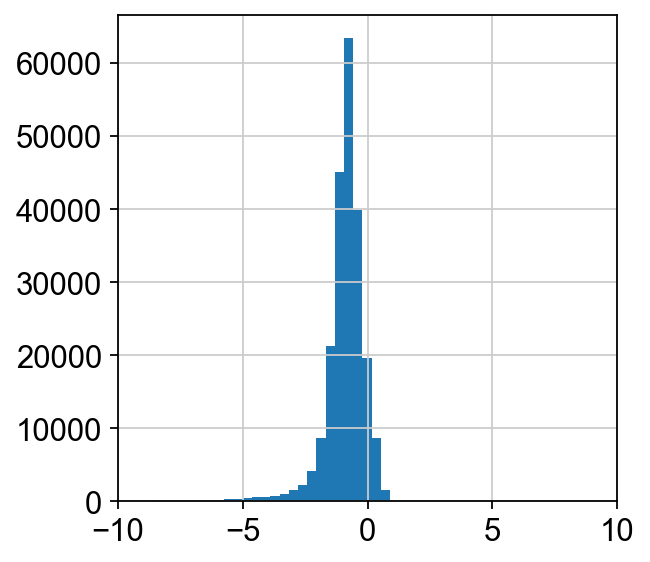

In [36]:
plt.hist(np.log10(results_adjacencies["importance"]), bins=50)
plt.xlim([-10, 10])

As targets genes have DNA motifs at promoters (sequence specific DNA motifs), those can be used to link TFs to target genes. Next, we use an annotation of TF associations to Transcription Start Sites (TSSs) to refine this annotation.

In [ ]:
! wget -nc https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather

In [39]:
import glob
import os

# ranking databases
db_glob = "*feather"
db_names = " ".join(glob.glob(db_glob))

In [40]:
db_names

'hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather'

In [ ]:
! wget -nc https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl

In [41]:
# motif databases
motif_path = "motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [42]:
# Using the catalog of motif and their gene associations at promoters, retrieved a subset adjacencies by pruning of the previous adjacencies.

if not os.path.exists('reg.csv'):
    !pyscenic ctx adj.csv \
        {db_names} \
        --annotations_fname {motif_path} \
        --expression_mtx_fname {loom_path} \
        --output reg.csv \
        --mask_dropouts \
        --num_workers {num_workers} > pyscenic_ctx_stdout.txt

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/mowp/mambaforge/en

To explore the candidates reported, it is recommended as a rule of thumb to explore the output by the ranking of relative contribution, or by top-quantile thresholds defined visually to obtain a high signal-to-noise ratio.

In [43]:
import numpy as np

n_genes_detected_per_cell = np.sum(adata_batch.X > 0, axis=1)
percentiles = pd.Series(n_genes_detected_per_cell.flatten().A.flatten()).quantile(
    [0.01, 0.05, 0.10, 0.50, 1]
)
print(percentiles)

0.01     101.0
0.05     144.0
0.10     171.0
0.50     259.0
1.00    1387.0
dtype: float64


The histogram below indicates the distribution of genes detected per cell. This visualization is convenient to define the parameter `--auc_threshold` in the next step. Specifically, the default parameter of `--auc_threshold` is 0.05, which in this plot would result in the selection of 144 genes, to be used as a reference per cell for AUCell calculations. The modification of this parameter affects the estimation of AUC values calculated by AUCell.

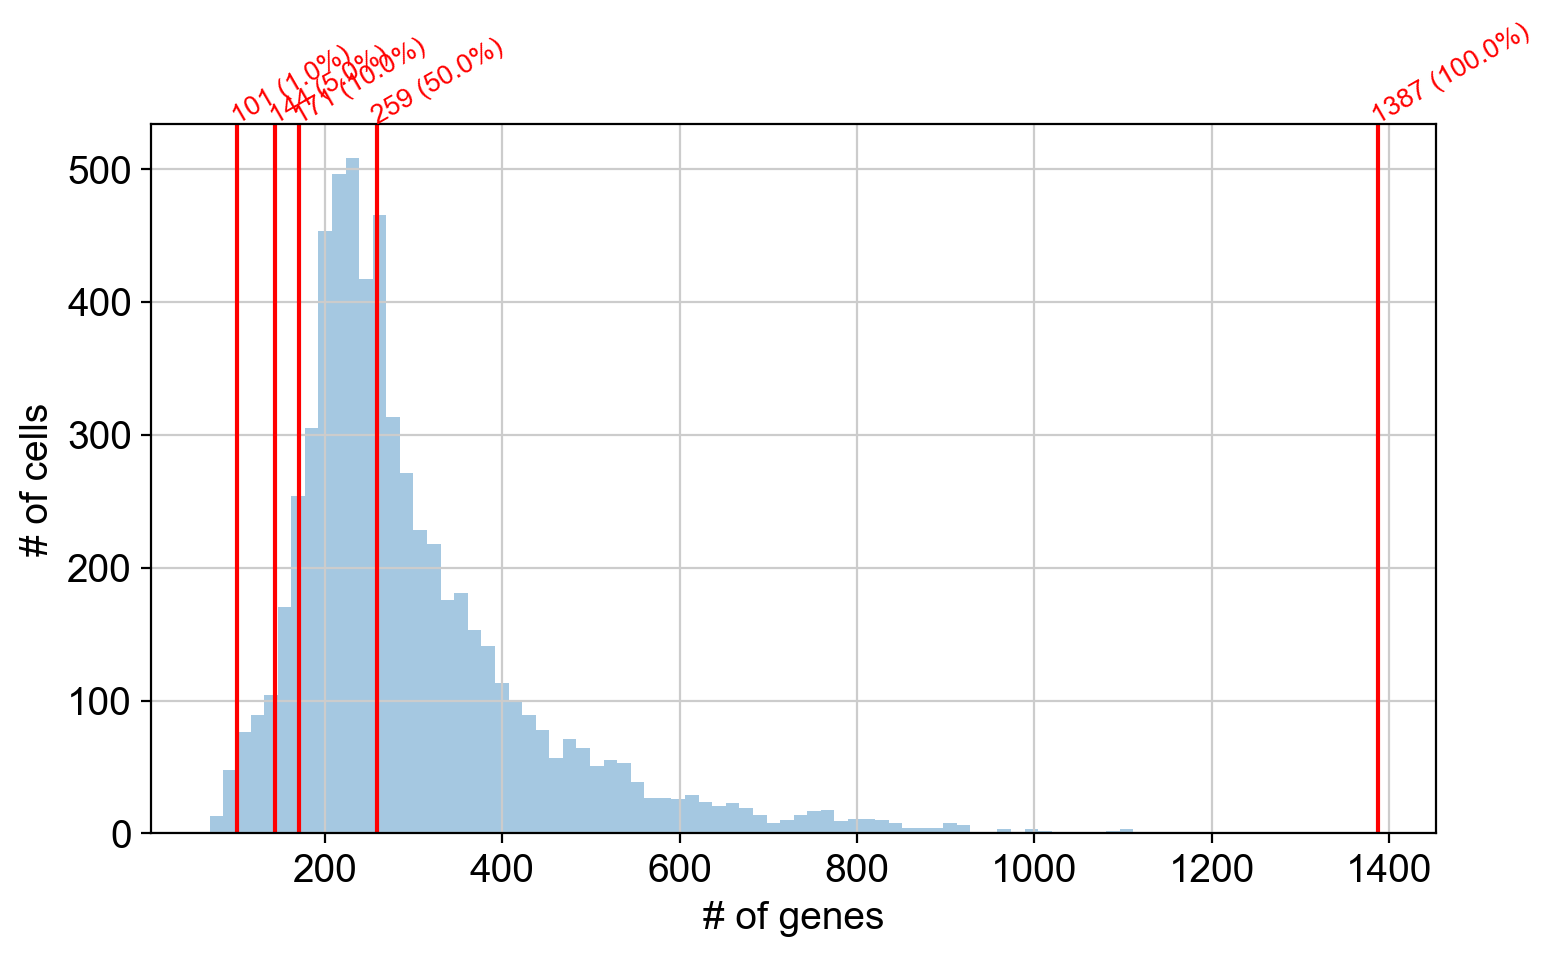

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)
sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")
for i, x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color="red")
    ax.text(
        x=x,
        y=ax.get_ylim()[1],
        s=f"{int(x)} ({percentiles.index.values[i]*100}%)",
        color="red",
        rotation=30,
        size="x-small",
        rotation_mode="anchor",
    )
ax.set_xlabel("# of genes")
ax.set_ylabel("# of cells")
fig.tight_layout()

This step will use TFs to calculate Area Under the Curve scores, that summarize how well the gene expression observed in each cell can be associated by the regulation of target genes regulatred by the mentioned TFs.

Using the above-generated matrix of cell x TFs and those scores, we can calculate a new embedding using only those.

In [49]:
if not os.path.exists(loom_path_output):
    !pyscenic aucell $loom_path \
        reg.csv \
        --output {loom_path_output} \
        --num_workers {num_workers} > pyscenic_aucell_stdout.txt

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/mowp/mambaforge/en

In [50]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect(loom_path_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [51]:
auc_mtx

,AHCTF1(+),ARG2(+),ARID3A(+),ATF3(+),ATF4(+),ATF6(+),ATF7(+),BBX(+),BCL3(+),BCLAF1(+),...,ZNF471(+),ZNF484(+),ZNF513(+),ZNF554(+),ZNF555(+),ZNF563(+),ZNF710(+),ZNF782(+),ZNF84(+),ZSCAN26(+)
TAGTTGTCACCCTCAC-1-s1d1,0.093525,0.000000,0.000000,0.033859,0.035971,0.000000,0.008355,0.029576,0.045221,0.002314,...,0.055156,0.000000,0.000000,0.086331,0.000000,0.000000,0.116136,0.0,0.000000,0.0
CTATGGCCATAACGGG-1-s1d1,0.000000,0.000000,0.001107,0.163818,0.003976,0.026259,0.024600,0.010592,0.000000,0.006591,...,0.025180,0.000000,0.000000,0.000000,0.000000,0.000000,0.133607,0.0,0.000000,0.0
CCGCACACAGGTTAAA-1-s1d1,0.065402,0.000000,0.017156,0.041251,0.000000,0.000000,0.011372,0.048161,0.000000,0.005987,...,0.065947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.136691,0.0
TCATTTGGTAATGGAA-1-s1d1,0.000000,0.000000,0.016049,0.049898,0.000000,0.049640,0.020190,0.007394,0.000000,0.006641,...,0.050360,0.053957,0.000000,0.000000,0.052358,0.120863,0.000000,0.0,0.000000,0.0
ACCACATAGGTGTCCA-1-s1d1,0.000000,0.000000,0.044272,0.136493,0.000000,0.000000,0.033883,0.060152,0.000000,0.023193,...,0.000000,0.000000,0.044707,0.000000,0.000000,0.000000,0.244604,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGACCCGGTTATCCTA-1-s1d1,0.000000,0.008633,0.003320,0.023431,0.008330,0.032734,0.000000,0.077938,0.054471,0.007546,...,0.098321,0.000000,0.000000,0.009592,0.018785,0.000000,0.000000,0.0,0.000000,0.0
GACCTAAGTGCCTCAC-1-s1d1,0.000000,0.000000,0.061151,0.054650,0.000000,0.000000,0.000000,0.067146,0.001028,0.002968,...,0.000000,0.064748,0.000000,0.000000,0.027178,0.000000,0.000000,0.0,0.000000,0.0
AGCTCATAGCTATATG-1-s1d1,0.028777,0.000000,0.000000,0.036499,0.016660,0.000000,0.018102,0.000000,0.123330,0.013181,...,0.000000,0.000000,0.000000,0.000000,0.003197,0.000000,0.000000,0.0,0.000000,0.0
TACGTACAGGAAACTG-1-s1d1,0.062132,0.000000,0.056170,0.027523,0.000189,0.000000,0.000000,0.017786,0.137718,0.000000,...,0.045564,0.000000,0.000000,0.000000,0.000000,0.000000,0.113052,0.0,0.000000,0.0


In [52]:
import anndata as ad

ad_auc_mtx = ad.AnnData(auc_mtx)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)
sc.tl.tsne(ad_auc_mtx)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [53]:
adata_batch.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]
adata_batch.obsm["X_tsne_aucell"] = ad_auc_mtx.obsm["X_tsne"]

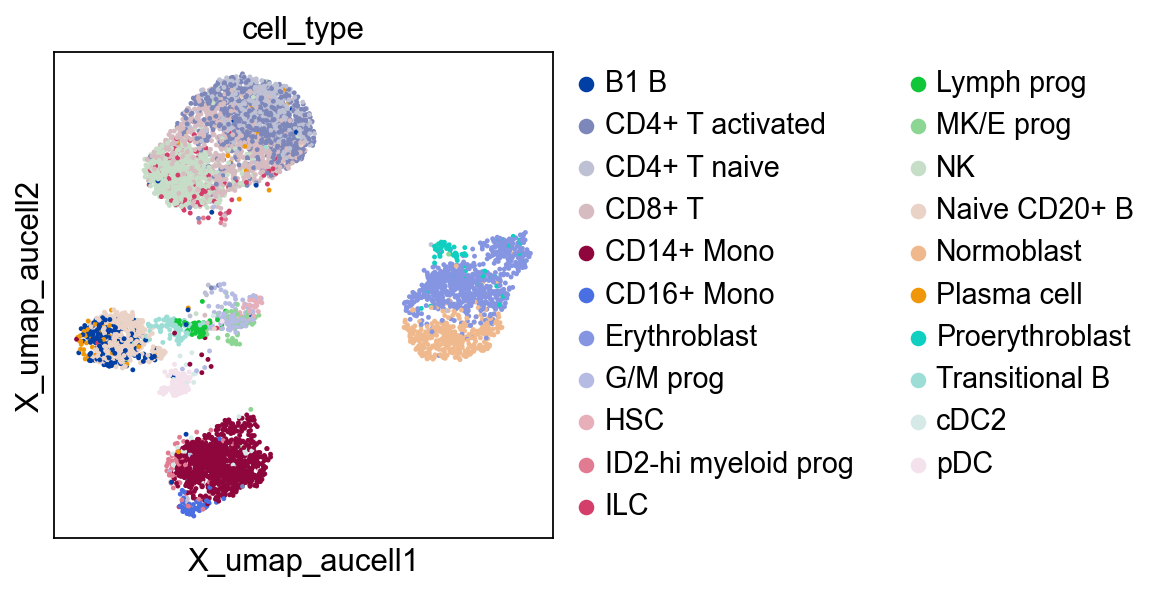

In [54]:
sc.pl.embedding(adata_batch, basis="X_umap_aucell", color="cell_type")

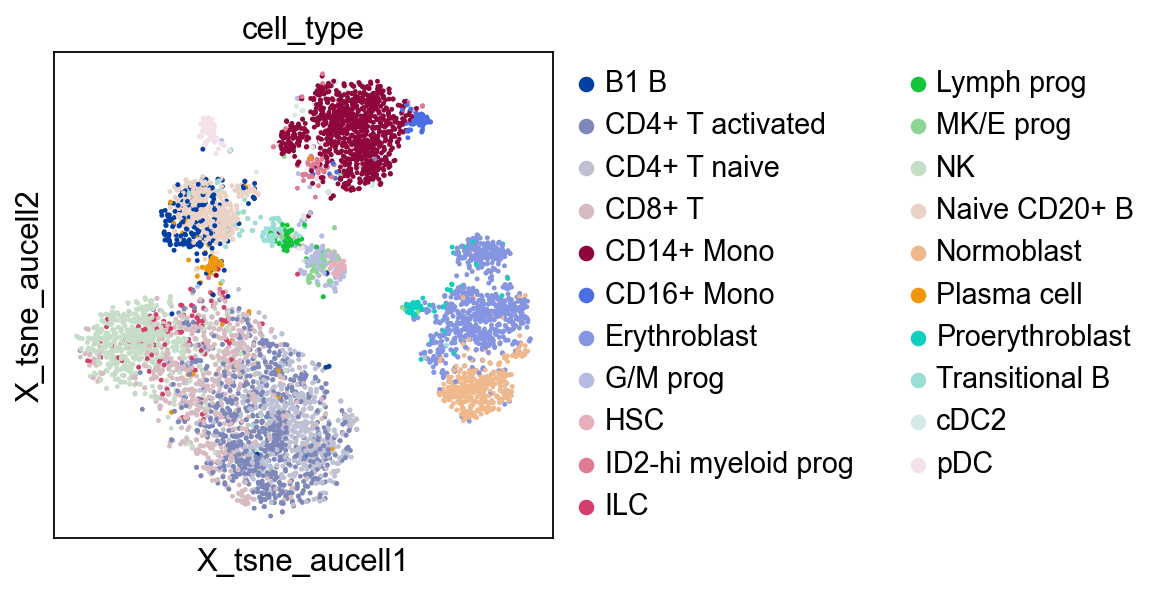

In [55]:
sc.pl.embedding(adata_batch, basis="X_tsne_aucell", color="cell_type")

## Interpretation of results

In [57]:
import seaborn as sns

In [58]:
auc_mtx["cell_type"] = adata_batch.obs["cell_type"]
mean_auc_by_cell_type = auc_mtx.groupby("cell_type").mean()

In [59]:
top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

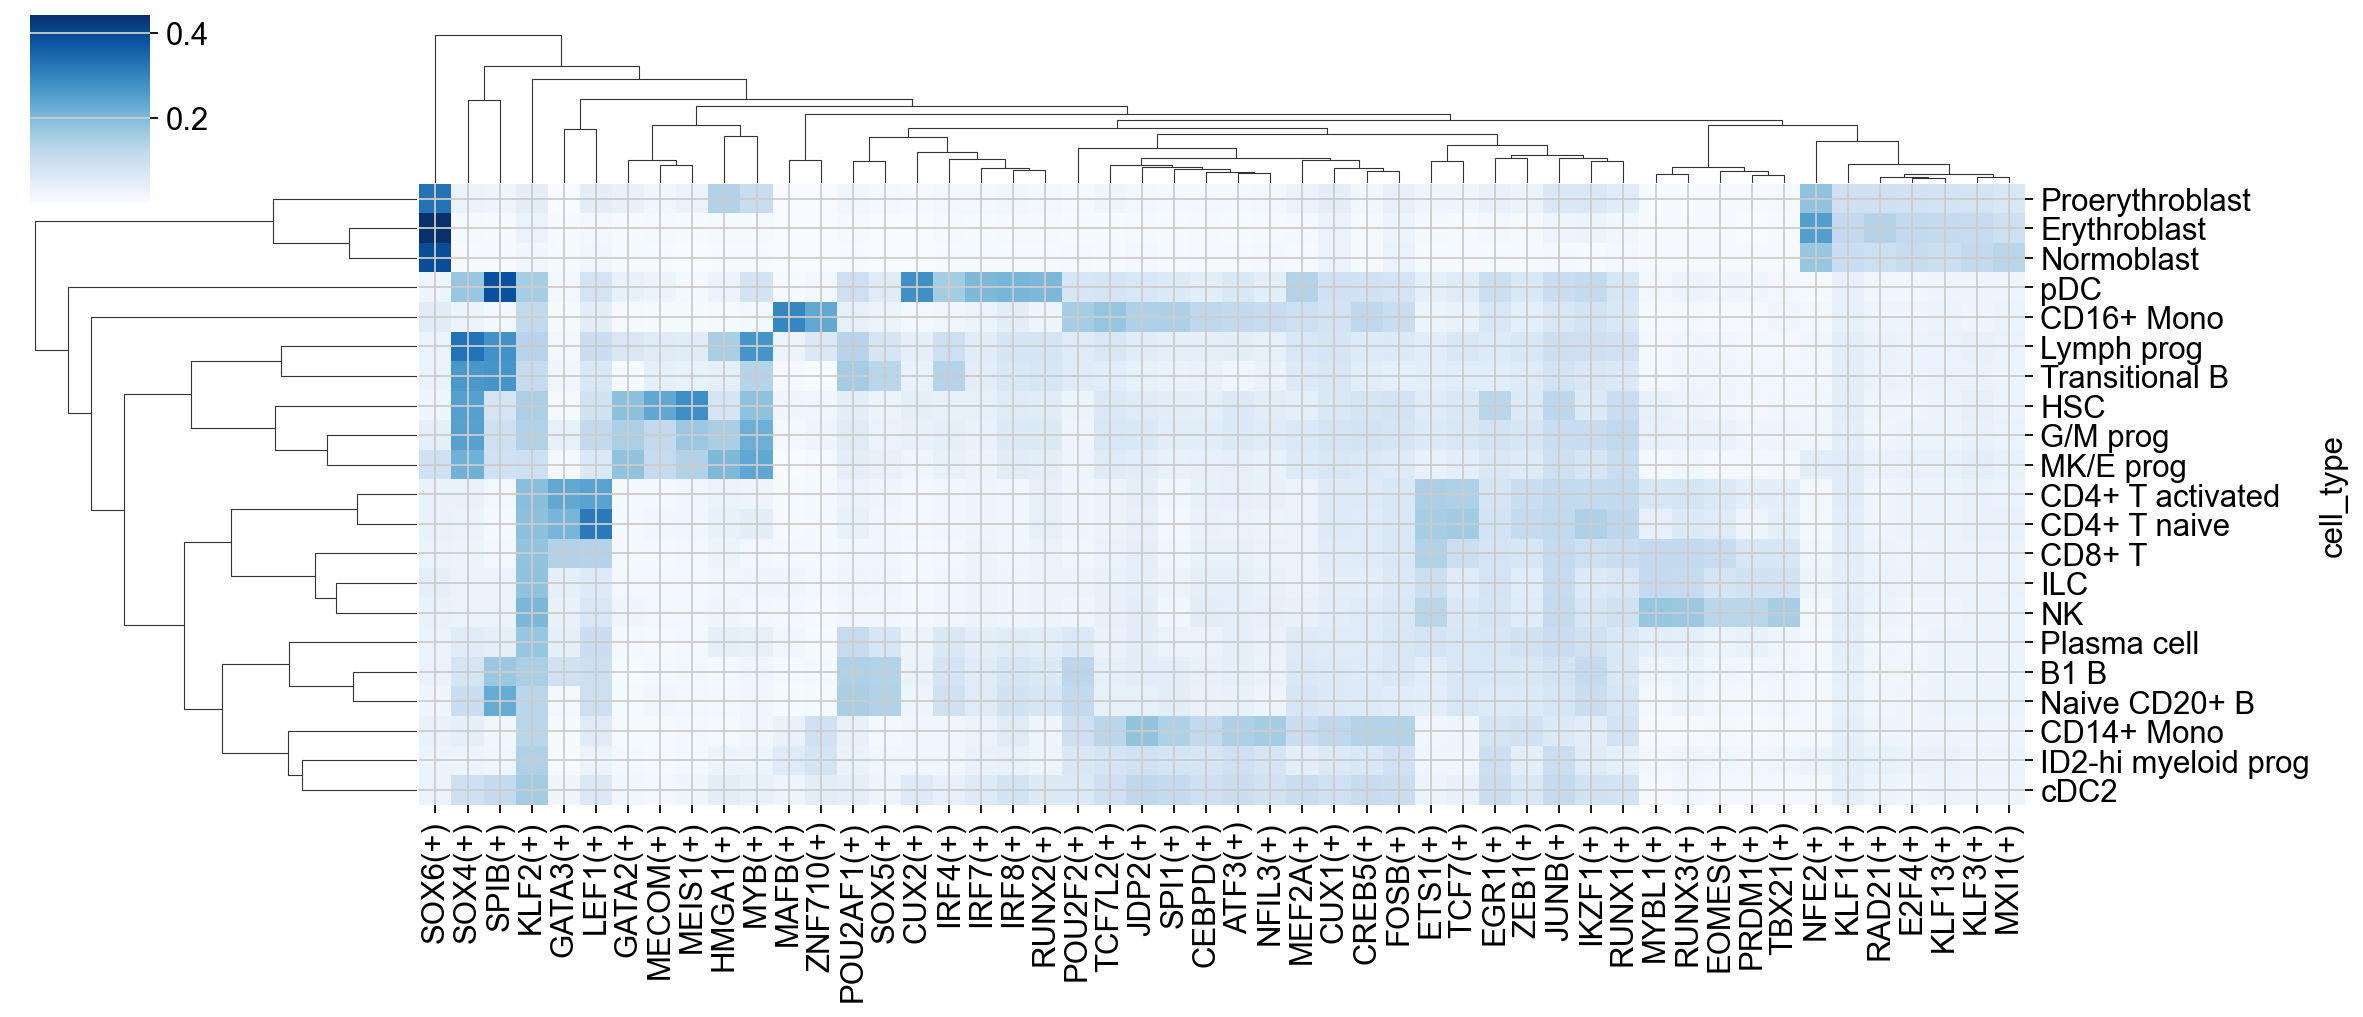

In [60]:
sns.clustermap(
    mean_auc_by_cell_type_top_n,
    figsize=[15, 6.5],
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
)

As the red heatmap is suggesting that some TFs are strongly associated to particular cell types, we can verify the expression of their expression levels as an additional validation. This is done by matching the TF names we want to highlight, and visualize those using Scanpy’s (red heatmap).

In [62]:
tf_names = top_tfs.index.str.replace("\(\+\)", "")
adata_batch_top_tfs = adata_batch[:, adata_batch.var_names.isin(tf_names)]

         Falling back to preprocessing with `sc.pp.pca` and default params.


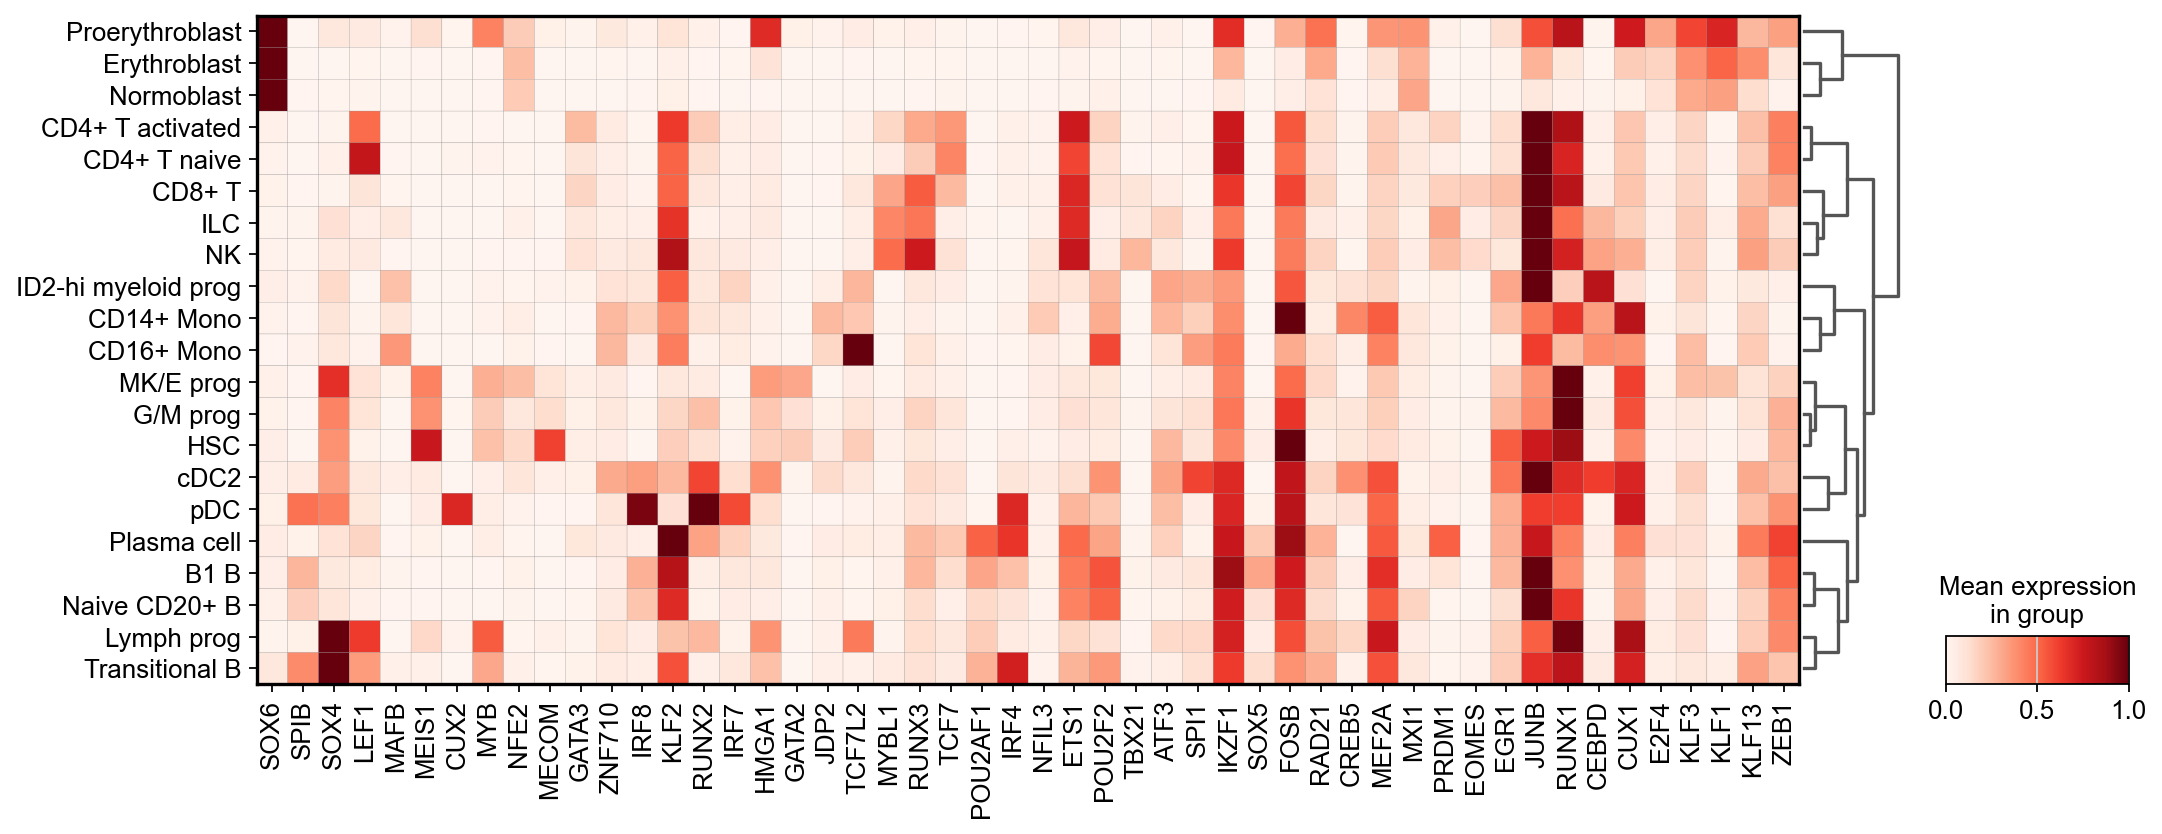

In [63]:
sc.pl.matrixplot(
    adata_batch,
    tf_names,
    groupby="cell_type",
    cmap="Reds",
    dendrogram=True,
    figsize=[15, 5.5],
    standard_scale="group",
)

Through visual inspection and comparison of the TF-regulon AUC scores and TF gene expression by cell type, we can verify that in several case the cell-type specific expression of a TF is linked to a particular cell type, where the respective TF-regulon is also active e.g. RUNX2 in pDCs, TCF7L2 in CD16+ Mono, LEF1 in CD4+ T activated. Additional inspection can serve to validate previous insights and/or additional associations.

In [64]:
import session_info


session_info.show()

In [67]:
! pyscenic

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/mowp/mambaforge/en